# Raw data analysis

Interpreting the raw data output from Quantum Design (QD) Magnetic Property Measurement System (MPMS) to understand how magnetic moment values are extracted from electrical readings.

Background understanding: [Quantum Design application notes](https://qdusa.com/support/applications_team.html)


# Introduction
[Fundamentals of Magnetism and Magnetic Measurements](https://qdusa.com/siteDocs/appNotes/FundPrimer.pdf)

A Superconducting Quantum Interference Device (SQUID) is used to detect and measure very small magnetic fields. This is not done directly, but by moving a magnetic sample of interest through a set of superconducting detection coils connected to the SQUID. As the sample moves through the detection coils, a persistent current is induced proportional to the changing magnetic flux. The SQUID converts this current to a voltage which is recorded and calibrated to accurately determine the sample magnetic moment.

<img src="./coil_schematic.svg" style="margin-left:auto; margin-right:auto"/>


Equation from [Subtracting the Sample Holder Background from Dilute Samples](https://qdusa.com/siteDocs/appNotes/1014-213.pdf)

An ideal voltage response curve of a magnetic dipole moving through the second order gradiometer geometry of the detection coils can be represented by the equation

$$
V = a + bz + c\left( 
2\left(R^2 + (z - d)^2\right)^{-3/2} 
- \left(R^2 + (z - d + \Lambda)^2\right)^{-3/2}
- \left(R^2 + (z - d - \Lambda)^2\right)^{-3/2}
\right)
$$

where $\Lambda = 1.519\textup{ cm}$ is the longitudinal coil separation and $R = 0.97\textup{ cm}$ is the longitudinal radius in the experimental setup. The fit parameters $a, b, c, d$ correspond to the following:

$a$ - Constant offset voltage

$b$ - Linear voltage drift in the SQUID during measurement

$c$ - Constant proportional to the sample magnetic moment

$d$ - Shift of the sample along the axis of the magnet

In [1]:
# basic imports and notebook initialization
import collections

%matplotlib widget
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import scipy.signal
import ipywidgets
import lmfit
import jupyter_black

plt.ioff()
jupyter_black.load()

In [2]:
# implementing the ideal voltage response equation
def squid_response(z, a, b, c, d, R=0.97, L=1.519):
    X = 2 * (R**2 + (z - d) ** 2) ** (-3 / 2)
    Y = (R**2 + (z - d + L) ** 2) ** (-3 / 2)
    Z = (R**2 + (z - d - L) ** 2) ** (-3 / 2)
    # account for possible non-linear/cyclic motion of sample for voltage drift
    # b*z -> b*k
    k = np.linspace(0, 1, len(z))
    return a + b * k + c * (X - Y - Z)

In [3]:
# interactive plot to demonstrate effect of fitting parameters

fig, ax = plt.subplots(1, 1, constrained_layout=True)
fig.suptitle("Idealized SQUID voltage response")
# ax.grid(color="0.9")
ax.axhline(color="k")
ax.axvline(color="k")
ax.set_xlabel("Position (cm)")
ax.set_ylabel("SQUID response (V)")
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)


def z(scan_width=4):
    # linear motion
    # return np.linspace(-scan_width / 2, scan_width / 2, 64)
    # sawtooth motion
    # return scan_width / 2 * scipy.signal.sawtooth(np.linspace(0, 2 * np.pi, 64), 0.5)
    # sinusoidal motion
    return -scan_width / 2 * np.cos(np.linspace(0, 2 * np.pi, 64))


(line,) = ax.plot([], [], marker=".", linestyle="-")

grid = ipywidgets.GridspecLayout(5, 1)
sliders = {}
for i, param in enumerate("abcd"):
    grid[i, 0] = sliders[param] = ipywidgets.FloatSlider(
        orientation="horizontal",
        description=param,
        value=0,
        min=-4,
        max=4,
        step=0.01,
        layout={"width": "700px"},
    )
sliders["c"].value = 2
grid[4, 0] = sliders["scan_width"] = ipywidgets.FloatSlider(
    orientation="horizontal",
    description="scan_width",
    value=4,
    min=0,
    max=6,
    step=0.1,
    layout={"width": "700px"},
)


def update(
    event=None,
    fig=fig,
    ax=ax,
    line=line,
):
    zi = z(scan_width=sliders["scan_width"].value)
    v = squid_response(zi, *[sliders[p].value for p in "abcd"])
    line.set_data(zi, v)
    fig.canvas.draw_idle()
    fig.canvas.flush_events()


for slider in sliders.values():
    slider.observe(update)

update()
ipywidgets.AppLayout(center=fig.canvas, footer=grid)

AppLayout(children=(GridspecLayout(children=(FloatSlider(value=0.0, description='a', layout=Layout(grid_area='…

# Loading data

Quantum Design MPMS data is saved as a text file in CSV (comma-separated values) format (.dat, .ndat), storing information such as measurement timestamp, temperature, extracted magnetic moment and fit factor. 

A measurement sequence can be set up to measure e.g. **temperature-dependence of magnetic moment** at a fixed applied field ("Zero field cooled/field cooled/field cooled warmed") or **field-dependence at fixed temperature** ("Hysteresis"), saving each set of data to a separate file for convenience.

`example.rso.dat`
<textarea 
    class="scrollabletextbox" name="note" 
    style="white-space: pre; overflow:scroll; overflow-y: scroll; overflow-x: scroll; width: 800px; height: 200px" 
    >
[Header]
TITLE,MPMS RSO Measurement
BYAPP,MPMS Measurement,1.1,Summary
FILEOPENTIME, 1473341040.718000 9/9/2016, 1:24:00 AM

INFO, APPNAME, MPMS MultiVu Application, Revision 1.61,  Build 082

INFO, NAME, A344
INFO, WEIGHT, 10.500
INFO, AREA, 1.000
INFO, LENGTH, 1.000
INFO, SHAPE, 0
INFO, COMMENT, m = 0.0105g
INFO, SEQUENCE FILE: FC_120K-5K.seq


INFO, BACKGROUND DATA FILE:, None


STARTUPAXIS,X,4,LINEAR,AUTO,0.000000,0.000000
STARTUPAXIS,Y1,5,LINEAR,AUTO,0.000000,0.000000


STARTUPGROUP,Longitudinal
FIELDGROUP,Longitudinal,1,2,3,4,5,6,7,8,9,10,11,19,20,21,22,23,35
FIELDGROUP,Transverse,1,2,3,4,12,13,14,15,16,17,18,24,25,26,27,28,35

PLOT_APPEARANCE,ALL,HORZ_GRID_ON,VERT_GRID_ON,MARKERS_AND_LINES

[Data]
Time,Comment,Field (Oe),Temperature (K),Long Moment (emu),Long Scan Std Dev,Long Offset (cm),Long Offset Std Dev,Long Algorithm,Long Reg Fit,Long Reg Factor,Trans Moment (emu),Trans Scan Std Dev,Trans Offset (cm),Trans Offset Std Dev,Trans Algorithm,Trans Reg Fit,Trans Reg Factor,Long Moment [w/o ABS] (emu),Long Scan Std Dev [w/o ABS],Long Offset [w/o ABS] (cm),Long Offset Std Dev [w/o ABS],Long Reg Fit [w/o ABS],Trans Moment [w/o ABS] (emu),Trans Scan Std Dev [w/o ABS],Trans Offset [w/o ABS] (cm),Trans Offset Std Dev [w/o ABS],Trans Reg Fit [w/o ABS],RSO Position (deg),Amplitude (cm),Frequency,Cycles to Average,Scans per Measurement,Delta Temp (K),Error,EC Comp. Running,Using ABS,
1473341040.700,,5.000000e+001,1.200089e+002,-4.277318e-006,0.000000e+000,9.325366e-002,0.000000e+000,3,2.364769e-001,1.825000e+000,,,,,,,,,,,,,,,,,,0,5.000000e+000,5.000000e-001,2,1,3.295898e-003,0,1,0,
1473341052.915,,5.000000e+001,1.200106e+002,-4.301953e-006,0.000000e+000,9.608114e-002,0.000000e+000,3,2.414699e-001,1.825000e+000,,,,,,,,,,,,,,,,,,0,5.000000e+000,5.000000e-001,2,1,0.000000e+000,0,1,0,
...
</textarea>

In [4]:
# parsing the QD MPMS data format
def load_mpms_file(fname):
    header = []
    with open(fname, "r") as f:
        # read header and count number of lines before [Data]
        for i, line in enumerate(f, start=1):
            if line.startswith("[Data]"):
                break
            if line.strip():
                header.append(line.strip())
    data = np.genfromtxt(
        fname, names=True, delimiter=",", skip_header=i, dtype=None, encoding="UTF-8"
    )
    return header, data

In [5]:
# setting up plot axes and plotting multiple data files
def plot_mpms_data(data=None, axes=None):
    if axes is None:
        fig, axes = plt.subplot_mosaic(
            [
                ["temperature_dependence", "field_dependence"],
                ["temperature_fit_factor", "field_fit_factor"],
            ],
            constrained_layout=True,
            height_ratios=[3, 1],
            figsize=(10, 5),
        )
        axes["temperature_dependence"].set_ylabel("Moment (emu)")
        axes["temperature_fit_factor"].set_xlabel("Temperature (K)")
        axes["field_fit_factor"].set_xlabel("Field (Oe)")
        axes["temperature_dependence"].sharex(axes["temperature_fit_factor"])
        axes["field_dependence"].sharex(axes["field_fit_factor"])
        axes["temperature_dependence"].tick_params(labelbottom=False)
        axes["field_dependence"].tick_params(labelbottom=False)
    if data is None:
        return axes
    temperature = data["Temperature_K"]
    field = data["Field_Oe"]
    moment = data["Long_Moment_emu"]
    fit_factor = data["Long_Reg_Fit"]
    if np.ptp(field) > 0:
        # plot field dependence
        axes["field_dependence"].plot(
            field,
            moment,
            marker=".",
            linestyle="--",
            label=f"{np.mean(temperature):02.0f} K",
        )
        axes["field_fit_factor"].plot(
            field,
            fit_factor,
            marker=".",
            linestyle="--",
            label=f"{np.mean(temperature):02.0f} K",
        )
    else:
        # plot temperature dependence
        # check if sample is warming or cooling
        is_warming = temperature[0] < temperature[-1]
        axes["temperature_dependence"].plot(
            temperature,
            moment,
            marker=".",
            linestyle="--",
            label=f"{np.mean(field):.1f} Oe - {'warming' if is_warming else 'cooling'}",
        )
        axes["temperature_fit_factor"].plot(
            temperature,
            fit_factor,
            marker=".",
            linestyle="--",
            label=f"{np.mean(field):.1f} Oe",
        )

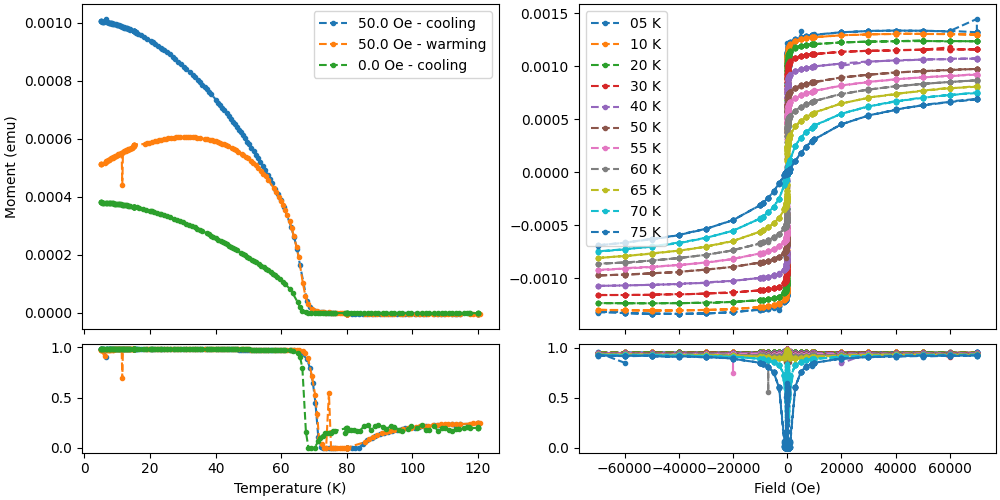

In [6]:
# loading and plotting ll *.dat files
files = sorted(pathlib.Path("./data/A344").glob("*.dat"))
axes = plot_mpms_data()
for file in files:
    header, data = load_mpms_file(file)
    plot_mpms_data(data=data, axes=axes)
axes["temperature_dependence"].legend()
axes["field_dependence"].legend()
plt.show()

# Loading raw data

In the Reciprocating Sample Option (RSO) mode, a scan consists of the voltage recorded as the sample moves up and down through the detection coils *n* times. The 
detector gain is normally automatically adjusted depending on the sample magnetic moment to keep the SQUID voltage within ±5 V to maintain high dynamic accuracy. The data file also records the scaled voltage accounting for the used gain and the software fit to the voltage response, saving the extracted emu value in the associated .dat file.

Each line in the data file corresponds to a voltage-sample position point -- (number of measurements) * (points per scan) 

`A344_GdN_FC_050_Oe_160908.rso.raw`
<textarea 
    class="scrollabletextbox" name="note" 
    style="white-space: pre; overflow:scroll; overflow-y: scroll; overflow-x: scroll; width: 800px; height: 200px" 
    >
[Header]
TITLE,MPMS RSO Measurement
BYAPP,MPMS Measurement,2.1,Raw with ABS
FILEOPENTIME, 1473341040.724000 9/9/2016, 1:24:00 AM

INFO, APPNAME, MPMS MultiVu Application, Revision 1.61,  Build 082

INFO, NAME, A344
INFO, WEIGHT, 10.500
INFO, AREA, 1.000
INFO, LENGTH, 1.000
INFO, SHAPE, 0
INFO, COMMENT, m = 0.0105g
INFO, SEQUENCE FILE: FC_120K-5K.seq


INFO, BACKGROUND DATA FILE:, None


STARTUPAXIS,X,8,LINEAR,AUTO,0.000000,0.000000
STARTUPAXIS,Y1,9,LINEAR,AUTO,0.000000,0.000000


STARTUPGROUP,Longitudinal
FIELDGROUP,Longitudinal,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
FIELDGROUP,Transverse,1,2,3,4,5,6,7,8,23,24,25,26,27,28,29,30,31,32,33,34,35,36

PLOT_APPEARANCE,ALL,HORZ_GRID_ON,VERT_GRID_ON,MARKERS_ONLY

[Data]
Time,Comment,Field (Oe),Start Temperature (K),End Temperature (K),Scan,Rejected,Position (cm),Long Voltage,Long Average Voltage,Long Detrended Voltage,Long Demeaned Voltage,Long Reg Fit,Long Detrended Fit,Long Demeaned Fit,Long Scaled Response,Long Avg. Scaled Response,Long Background Response,Long Response [w/ABS],Long Detrended Resp. [w/ABS],Long Fit [w/ABS],Long Detrended Fit [w/ABS],Trans Voltage,Trans Average Voltage,Trans Detrended Voltage,Trans Demeaned Voltage,Trans Reg Fit,Trans Detrended Fit,Trans Demeaned Fit,Trans Scaled Response,Trans Avg. Scaled Response,Trans Background Response,Trans Response [w/ABS],Trans Detrended Resp. [w/ABS],Trans Adjusted Fit,Trans Detrended Fit [w/ABS],
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,2.591049e+000,-4.577776e-002,-4.577776e-002,-4.353184e-001,-4.353184e-001,1.013245e-001,-2.882161e-001,-2.882161e-001,-1.146691e-006,-1.146691e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,2.365994e+000,-7.629627e-003,-7.629627e-003,-3.911923e-001,-3.971703e-001,1.249255e-001,-2.586372e-001,-2.646152e-001,-1.911151e-007,-1.911151e-007,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,2.139604e+000,8.377331e-002,8.377331e-002,-2.938115e-001,-3.057674e-001,1.905633e-001,-1.870214e-001,-1.989773e-001,2.098444e-006,2.098444e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,1.914313e+000,2.000488e-001,2.000488e-001,-1.715580e-001,-1.894918e-001,2.688358e-001,-1.027711e-001,-1.207049e-001,5.011038e-006,5.011038e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,1.692222e+000,3.297525e-001,3.297525e-001,-3.587637e-002,-5.978817e-002,3.425446e-001,-2.308426e-002,-4.699606e-002,8.259995e-006,8.259995e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,1.475019e+000,4.704428e-001,4.704428e-001,1.107919e-001,8.090216e-002,4.053873e-001,4.573642e-002,1.584667e-002,1.178416e-005,1.178416e-005,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,1.264075e+000,6.009095e-001,6.009095e-001,2.472365e-001,2.113688e-001,4.508149e-001,9.714193e-002,6.127423e-002,1.505222e-005,1.505222e-005,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,1.060690e+000,6.807154e-001,6.807154e-001,3.330204e-001,2.911747e-001,4.708865e-001,1.231915e-001,8.134583e-002,1.705129e-005,1.705129e-005,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,8.664142e-001,6.619465e-001,6.619465e-001,3.202294e-001,2.724058e-001,4.652248e-001,1.235077e-001,7.568413e-002,1.658115e-005,1.658115e-005,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,6.833521e-001,5.800043e-001,5.800043e-001,2.442652e-001,1.904636e-001,4.437052e-001,1.079660e-001,5.416450e-002,1.452857e-005,1.452857e-005,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,5.143535e-001,4.670858e-001,4.670858e-001,1.373246e-001,7.754511e-002,4.178687e-001,8.810753e-002,2.832803e-002,1.170007e-005,1.170007e-005,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,3.630108e-001,3.651540e-001,3.651540e-001,4.137074e-002,-2.438670e-002,3.943423e-001,7.055908e-002,4.801631e-003,9.146768e-006,9.146768e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,2.334378e-001,2.777184e-001,2.777184e-001,-4.008685e-002,-1.118222e-001,3.751392e-001,5.733390e-002,-1.440150e-002,6.956589e-006,6.956589e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,1.298506e-001,2.122562e-001,2.122562e-001,-9.957109e-002,-1.772844e-001,3.600941e-001,4.826680e-002,-2.944654e-002,5.316822e-006,5.316822e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,5.602222e-002,1.655629e-001,1.655629e-001,-1.402865e-001,-2.239778e-001,3.484725e-001,4.262310e-002,-4.106820e-002,4.147198e-006,4.147198e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,1.471969e-002,1.399274e-001,1.399274e-001,-1.599441e-001,-2.496133e-001,3.396201e-001,3.974868e-002,-4.992056e-002,3.505051e-006,3.505051e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,7.241501e-003,1.371807e-001,1.371807e-001,-1.567128e-001,-2.523600e-001,3.331426e-001,3.924910e-002,-5.639809e-002,3.436249e-006,3.436249e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,3.315883e-002,1.513718e-001,1.513718e-001,-1.365437e-001,-2.381689e-001,3.289232e-001,4.100764e-002,-6.061751e-002,3.791723e-006,3.791723e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,9.032404e-002,1.838740e-001,1.838740e-001,-9.806355e-002,-2.056666e-001,3.271004e-001,4.516279e-002,-6.244031e-002,4.605874e-006,4.605874e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,1.751551e-001,2.389599e-001,2.389599e-001,-3.699971e-002,-1.505807e-001,3.280242e-001,5.206458e-002,-6.151646e-002,5.985725e-006,5.985725e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,2.831470e-001,3.123569e-001,3.123569e-001,4.237527e-002,-7.718372e-002,3.321498e-001,6.216809e-002,-5.739090e-002,7.824252e-006,7.824252e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,4.095127e-001,3.970458e-001,3.970458e-001,1.330421e-001,7.505149e-003,3.397662e-001,7.576247e-002,-4.977447e-002,9.945629e-006,9.945629e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,5.498305e-001,4.916532e-001,4.916532e-001,2.336274e-001,1.021125e-001,3.504080e-001,9.238221e-002,-3.913268e-002,1.231546e-005,1.231546e-005,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,7.005737e-001,5.854976e-001,5.854976e-001,3.334498e-001,1.959569e-001,3.618690e-001,1.098212e-001,-2.767166e-002,1.466617e-005,1.466617e-005,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,8.594255e-001,6.559954e-001,6.559954e-001,4.099255e-001,2.664547e-001,3.692061e-001,1.231362e-001,-2.033460e-002,1.643208e-005,1.643208e-005,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,1.025330e+000,6.787316e-001,6.787317e-001,4.386398e-001,2.891910e-001,3.650436e-001,1.249516e-001,-2.449712e-002,1.700160e-005,1.700160e-005,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,1.198287e+000,6.239509e-001,6.239509e-001,3.898369e-001,2.344102e-001,3.425803e-001,1.084663e-001,-4.696041e-002,1.562939e-005,1.562939e-005,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,1.378954e+000,5.227820e-001,5.227821e-001,2.946461e-001,1.332414e-001,2.997584e-001,7.162240e-002,-8.978224e-002,1.309521e-005,1.309521e-005,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,1.568149e+000,3.910947e-001,3.910947e-001,1.689366e-001,1.554012e-003,2.398295e-001,1.767143e-002,-1.497112e-001,9.796559e-006,9.796559e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,1.766382e+000,2.665792e-001,2.665792e-001,5.039905e-002,-1.229615e-001,1.673013e-001,-4.887888e-002,-2.222394e-001,6.677561e-006,6.677561e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,1.973500e+000,1.477096e-001,1.477096e-001,-6.249259e-002,-2.418311e-001,8.523997e-002,-1.249622e-001,-3.043007e-001,3.699988e-006,3.699988e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,2.188529e+000,4.089480e-002,4.089480e-002,-1.633294e-001,-3.486459e-001,-2.640579e-004,-2.044883e-001,-3.898047e-001,1.024377e-006,1.024377e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,2.409722e+000,-3.845332e-002,-3.845332e-002,-2.366996e-001,-4.279940e-001,-7.029424e-002,-2.685405e-001,-4.598349e-001,-9.632201e-007,-9.632201e-007,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,2.634777e+000,-5.371258e-002,-5.371258e-002,-2.459809e-001,-4.432532e-001,-9.490616e-002,-2.871745e-001,-4.844468e-001,-1.345450e-006,-1.345450e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,2.861167e+000,-2.533036e-002,-2.533036e-002,-2.116207e-001,-4.148710e-001,-6.169603e-002,-2.479864e-001,-4.512367e-001,-6.345021e-007,-6.345021e-007,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,3.086458e+000,1.937925e-002,1.937925e-002,-1.609332e-001,-3.701614e-001,7.822502e-003,-1.724899e-001,-3.817182e-001,4.854323e-007,4.854323e-007,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,3.308549e+000,5.340739e-002,5.340739e-002,-1.209271e-001,-3.361333e-001,8.505477e-002,-8.927972e-002,-3.044859e-001,1.337806e-006,1.337806e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,3.525752e+000,7.477035e-002,7.477035e-002,-9.358619e-002,-3.147703e-001,1.559161e-001,-1.244049e-002,-2.336246e-001,1.872928e-006,1.872928e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,3.736696e+000,8.972441e-002,8.972442e-002,-7.265417e-002,-2.998163e-001,2.152443e-001,5.286572e-002,-1.742964e-001,2.247514e-006,2.247514e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,3.940081e+000,9.933775e-002,9.933775e-002,-5.706289e-002,-2.902029e-001,2.568352e-001,1.004346e-001,-1.327055e-001,2.488319e-006,2.488319e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,4.134357e+000,1.033052e-001,1.033052e-001,-4.711754e-002,-2.862355e-001,2.741143e-001,1.236916e-001,-1.154264e-001,2.587698e-006,2.587698e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,4.317419e+000,1.116977e-001,1.116977e-001,-3.274699e-002,-2.778429e-001,2.680887e-001,1.236439e-001,-1.214520e-001,2.797925e-006,2.797925e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,4.486418e+000,1.193274e-001,1.193274e-001,-1.913942e-002,-2.702133e-001,2.482366e-001,1.097698e-001,-1.413041e-001,2.989040e-006,2.989040e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,4.637760e+000,1.232948e-001,1.232948e-001,-9.194061e-003,-2.662459e-001,2.247404e-001,9.225161e-002,-1.648002e-001,3.088420e-006,3.088420e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,4.767334e+000,1.277200e-001,1.277200e-001,1.209078e-003,-2.618207e-001,2.033797e-001,7.686883e-002,-1.861610e-001,3.199267e-006,3.199267e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,4.870921e+000,1.309244e-001,1.309244e-001,1.039146e-002,-2.586163e-001,1.860199e-001,6.548698e-002,-2.035208e-001,3.279535e-006,3.279535e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,4.944749e+000,1.309244e-001,1.309244e-001,1.636941e-002,-2.586163e-001,1.726764e-001,5.812142e-002,-2.168643e-001,3.279535e-006,3.279535e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,4.986052e+000,1.336711e-001,1.336711e-001,2.509403e-002,-2.558696e-001,1.628758e-001,5.429879e-002,-2.266648e-001,3.348337e-006,3.348337e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,4.993530e+000,1.332133e-001,1.332133e-001,3.061420e-002,-2.563274e-001,1.562290e-001,5.362991e-002,-2.333117e-001,3.336870e-006,3.336870e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,4.967612e+000,1.301614e-001,1.301614e-001,3.354031e-002,-2.593792e-001,1.525997e-001,5.597854e-002,-2.369410e-001,3.260423e-006,3.260423e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,4.910447e+000,1.315348e-001,1.315348e-001,4.089158e-002,-2.580059e-001,1.521033e-001,6.146007e-002,-2.374374e-001,3.294824e-006,3.294824e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,4.825616e+000,1.275674e-001,1.275674e-001,4.290212e-002,-2.619733e-001,1.549923e-001,7.032710e-002,-2.345483e-001,3.195444e-006,3.195444e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,4.717624e+000,1.193274e-001,1.193274e-001,4.064008e-002,-2.702133e-001,1.613621e-001,8.267482e-002,-2.281786e-001,2.989040e-006,2.989040e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,4.591259e+000,1.211585e-001,1.211585e-001,4.844914e-002,-2.683822e-001,1.705413e-001,9.783200e-002,-2.189993e-001,3.034908e-006,3.034908e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,4.450941e+000,1.164281e-001,1.164281e-001,4.969672e-002,-2.731126e-001,1.801338e-001,1.134024e-001,-2.094069e-001,2.916416e-006,2.916416e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,4.300197e+000,1.071200e-001,1.071200e-001,4.636652e-002,-2.824207e-001,1.851936e-001,1.244401e-001,-2.043471e-001,2.683256e-006,2.683256e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,4.141346e+000,1.025422e-001,1.025422e-001,4.776670e-002,-2.869985e-001,1.788406e-001,1.240651e-001,-2.107000e-001,2.568587e-006,2.568587e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,3.975441e+000,9.399701e-002,9.399701e-002,4.519947e-002,-2.955437e-001,1.552708e-001,1.064732e-001,-2.342699e-001,2.354538e-006,2.354538e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,3.802484e+000,8.987702e-002,8.987701e-002,4.705741e-002,-2.996637e-001,1.131686e-001,7.034901e-002,-2.763721e-001,2.251336e-006,2.251336e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,3.621818e+000,7.599109e-002,7.599109e-002,3.914944e-002,-3.135496e-001,5.559886e-002,1.875721e-002,-3.339418e-001,1.903506e-006,1.903506e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,3.432622e+000,5.981628e-002,5.981628e-002,2.895258e-002,-3.297244e-001,-1.360324e-002,-4.446694e-002,-4.031439e-001,1.498342e-006,1.498342e-006,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,3.234389e+000,3.158666e-002,3.158666e-002,6.700911e-003,-3.579540e-001,-9.203511e-002,-1.169209e-001,-4.815758e-001,7.912165e-007,7.912165e-007,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,3.027271e+000,-4.882962e-003,-4.882962e-003,-2.379076e-002,-3.944236e-001,-1.752025e-001,-1.941103e-001,-5.647432e-001,-1.223137e-007,-1.223137e-007,,,,,,,,,,,,,,,,,,,,
1473341040.700,,5.000000e+001,1.200106e+002,1.200073e+002,1,0,2.812242e+000,-5.157628e-002,-5.157628e-002,-6.450613e-002,-4.411170e-001,-2.477108e-001,-2.606406e-001,-6.372514e-001,-1.291938e-006,-1.291938e-006,,,,,,,,,,,,,,,,,,,,
1473341052.915,,5.000000e+001,1.200106e+002,1.200106e+002,1,0,2.590928e+000,-3.051851e-002,-3.051851e-002,-4.347720e-001,-4.347720e-001,1.143906e-001,-2.898629e-001,-2.898629e-001,-7.644604e-007,-7.644604e-007,,,,,,,,,,,,,,,,,,,,
1473341052.915,,5.000000e+001,1.200106e+002,1.200106e+002,1,0,2.365852e+000,6.256294e-003,6.256294e-003,-3.921485e-001,-3.979972e-001,1.390156e-001,-2.593893e-001,-2.652379e-001,1.567144e-007,1.567144e-007,,,,,,,,,,,,,,,,,,,,
1473341052.915,,5.000000e+001,1.200106e+002,1.200106e+002,1,0,2.139447e+000,9.475998e-002,9.475997e-002,-2.977962e-001,-3.094935e-001,2.055495e-001,-1.870066e-001,-1.987039e-001,2.373650e-006,2.373650e-006,,,,,,,,,,,,,,,,,,,,
1473341052.915,,5.000000e+001,1.200106e+002,1.200106e+002,1,0,1.914152e+000,2.134770e-001,2.134770e-001,-1.732305e-001,-1.907765e-001,2.844649e-001,-1.022425e-001,-1.197886e-001,5.347400e-006,5.347400e-006,,,,,,,,,,,,,,,,,,,,
1473341052.915,,5.000000e+001,1.200106e+002,1.200106e+002,1,0,1.692067e+000,3.469954e-001,3.469954e-001,-3.386332e-002,-5.725804e-002,3.586642e-001,-2.219452e-002,-4.558924e-002,8.691914e-006,8.691914e-006,,,,,,,,,,,,,,,,,,,,
...
</textarea>

In [7]:
# associated loading of .dat and .raw files
def load_sample_data(sample):
    data = collections.defaultdict(dict)
    for p in (pathlib.Path("./data") / sample).glob("*"):
        if p.suffix == ".raw":
            data[p.stem]["raw"] = load_mpms_file(p)[1]
        elif p.suffix == ".dat":
            data[p.stem]["dat"] = load_mpms_file(p)[1]
    return data


A344 = load_sample_data("A344")

In [8]:
# Demonstrating basic .raw data viewer
def raw_scan_viewer(raw_dat):
    raw = raw_dat["raw"]
    dat = raw_dat["dat"]
    n_scans = len(set(raw["Time"]))  # counting number of unique timestamps
    scans = raw.reshape(n_scans, -1)  # nth scan accessible by scans[n]

    temperature = dat["Temperature_K"]
    moment = dat["Long_Moment_emu"]

    fig2, (ax2, ax3) = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 5))
    (raw_line,) = ax2.plot([], [], linestyle="--", marker=".", label="Raw")
    (mpms_fit,) = ax2.plot([], [], linestyle="--", marker=".", label="MPMS fit")
    (fc_line,) = ax3.plot(temperature, moment, marker="o", picker=5)
    (fc_selected,) = ax3.plot([], [], marker="o", linestyle="")
    ax2.set_ylabel("Voltage (V)")
    ax2.set_xlabel("Position (cm)")
    ax3.set_ylabel("Magnetic moment (emu)")

    scan_slider = ipywidgets.IntSlider(
        orientation="horizontal",
        description="Scan #",
        value=0,
        min=0,
        max=n_scans - 1,
        layout={"width": "700px"},
    )

    def raw_update(
        event=None,
        fig=fig2,
        ax=ax2,
        temperature=temperature,
        moment=moment,
    ):
        idx = scan_slider.value
        scan = scans[idx]
        raw_line.set_data(scan["Position_cm"], scan["Long_Scaled_Response"])
        # correcting for measurement gain
        scale_factor = scan["Long_Scaled_Response"] / scan["Long_Voltage"]
        mpms_fit.set_data(scan["Position_cm"], scan["Long_Reg_Fit"] * scale_factor)
        # highlight selected point
        fc_selected.set_data([temperature[idx]], [moment[idx]])
        ax.relim()
        ax.autoscale()
        fig.canvas.draw_idle()
        fig.canvas.flush_events()

    def select_scan(event=None):
        idx = np.clip(event.ind[0], 0, n_scans - 1)
        scan_slider.value = idx

    fig2.canvas.mpl_connect("pick_event", select_scan)

    scan_slider.observe(raw_update)
    raw_update()
    return ipywidgets.AppLayout(center=fig2.canvas, footer=scan_slider)

In [9]:
raw_scan_viewer(A344["A344_GdN_FC_050_Oe_160908.rso"])

AppLayout(children=(IntSlider(value=0, description='Scan #', layout=Layout(grid_area='footer', width='700px'),…

In [10]:
# creating lmfit model for fitting multiple dipoles to raw voltage scans
def background(z, a=0, b=0):
    k = np.linspace(0, 1, len(z))
    return a + b * k


def dipole_response(z, c=0, center=0):
    R = 0.97
    L = 1.519
    # dipole response without offset and drift
    X = 2 * (R**2 + (z - center) ** 2) ** (-3 / 2)
    Y = (R**2 + (z - center + L) ** 2) ** (-3 / 2)
    Z = (R**2 + (z - center - L) ** 2) ** (-3 / 2)
    return c * (X - Y - Z)


def n_dipole_model(centers=(2.5,), allowed_shift=0.2):
    n = len(centers)
    bg = lmfit.Model(background, prefix="bg_")
    dipoles = []
    for i, center in enumerate(centers):
        dipole = lmfit.Model(dipole_response, prefix=f"d{i}_")
        dipole.set_param_hint(
            f"d{i}_center",
            value=center,
            min=center - allowed_shift,
            max=center + allowed_shift,
        )
        dipoles.append(dipole)
    return sum(dipoles, start=bg)


def plot_res_components(res):
    fig, ax = plt.subplots(1, 1, constrained_layout=True)
    ivar = res.model.independent_vars[0]
    x = res.userkws[ivar]
    y = res.data
    ax.plot(x, y, linestyle="--", marker="o", label="Raw data")
    for component in res.components:
        y_c = component.eval(params=res.params, **res.userkws)
        ax.plot(x, y_c, linestyle="-", label=component.prefix)
    ax.plot(x, res.best_fit)
    ax.legend()
    return ax

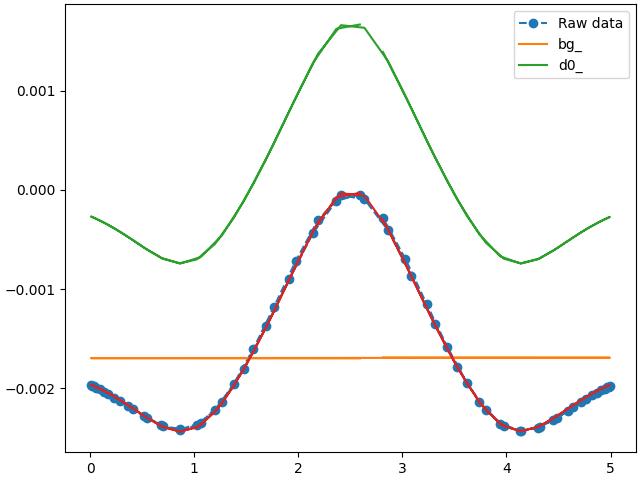

In [11]:
# single dipole fit
raw = A344["A344_GdN_FC_050_Oe_160908.rso"]["raw"]
n_scans = len(set(raw["Time"]))  # counting number of unique timestamps
scans = raw.reshape(n_scans, -1)  # nth scan accessible by scans[n]
res = n_dipole_model([2.5]).fit(
    scans[171]["Long_Scaled_Response"], z=scans[171]["Position_cm"]
)
plot_res_components(res)
plt.show()

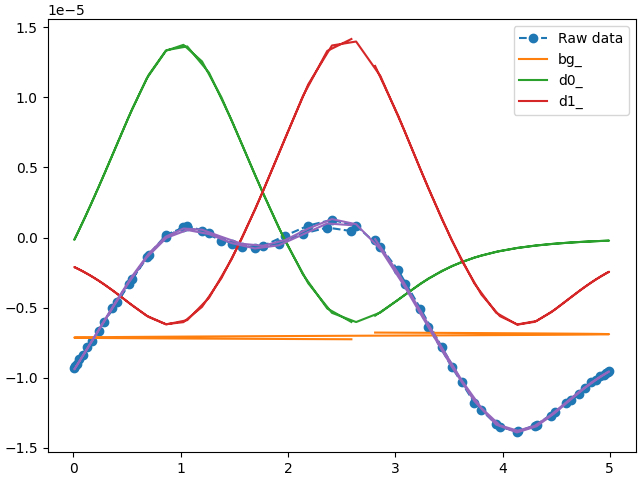

In [12]:
# two dipole fit
i = 47
centers = [1.02, 2.45]
res = n_dipole_model(centers).fit(
    scans[i]["Long_Scaled_Response"], z=scans[i]["Position_cm"]
)
plot_res_components(res)
plt.show()

In [13]:
# fitting two dipoles to all scans
centers = [1.02, 2.45]
model = n_dipole_model(centers)
ress = [
    model.fit(scan["Long_Scaled_Response"], z=scan["Position_cm"]) for scan in scans
]

In [14]:
ress[0]

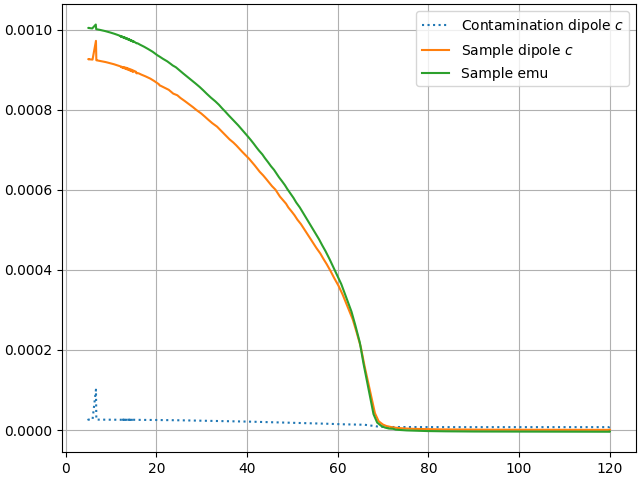

In [15]:
dat = A344["A344_GdN_FC_050_Oe_160908.rso"]["dat"]
fig3, ax3 = plt.subplots(1, 1, constrained_layout=True)
ax3.grid()
temperature = [scan["Start_Temperature_K"].mean() for scan in scans]
contamination_dipole = [res.best_values["d0_c"] for res in ress]
sample_dipole = [res.best_values["d1_c"] for res in ress]
ax3.plot(
    temperature, contamination_dipole, linestyle=":", label="Contamination dipole $c$"
)
ax3.plot(temperature, sample_dipole, label="Sample dipole $c$")
ax3.plot(dat["Temperature_K"], dat["Long_Moment_emu"], label="Sample emu")
ax3.legend()
plt.show()